In [100]:
import pandas as pd
from scipy.io import arff

import plotly
plotly.tools.set_credentials_file(username='artemii-yanushevskyi', api_key='aRmQfG7U4SAlhISYVym7')

import plotly.plotly as py
import plotly.graph_objs as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from IPython.display import Image
import plotly.io as pio

import numpy as np
import seaborn as sns

from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
colormap = plt.cm.RdBu

exporting = True

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold

import importlib
import assistmodule

# Abstract

This report demonstrates the full process of developing a data mining solution for marketing campaign dataset, including critical insights and limitation of the solution, and how it could be improved.

As stated in the coursework specification for the solution, the goal of our first model is to predict, as accurately as possible, whether or not a client will subscribe to a term deposit. The goal of the second model for cost-sensitive classification is to make the total cost as small as possible. I apply multiple techniques like Feature Engineering, Parameter Tuning, and Boosting. Besides, I provide justifications on its impact on the prediction accuracy for equal cost classification and on the decrease the cost value for cost-sensitive classification.


# Introduction


We are given with the dataset about marketing campaigns that were based on phone calls. Each entry in the dataset corresponds to someone who has subscribed to a bank term deposit or not. Often more than one contact to the same client was required, in order to confirm if the product would (or not) be subscribed to.

The tools that I will use to develop the models are *Python* programming language, equipped with popular data mining library *sci-kit-learn*, data-frame manipulation library *Pandas*, mathematical library *NumPy*, and visualisation libraries *Plotly* and *Matplotlib*.

# Data Exploration

The dataset was supplied as an `arrf` file. The general description for attributes and statistics are the following

In [101]:
data, meta = arff.loadarff('cworkTrain.arff')
df = pd.DataFrame(data)

# all categorical attributes are in binary format

df = assistmodule.decode_dataframe(df)

display(
    'The dataset contains {} entries and {} attributes.'.format(*df.shape),
    df.head(),
    'There are 9 categorical and 8 numerical attributes.',
    'The statistics for categorical attributes:',
    df.select_dtypes([object]).describe(), 
    'The statistics for numerical attributes:',
    df.select_dtypes([float, int]).describe().round(1)
)

'The dataset contains 36169 entries and 17 attributes.'

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,termDeposit
0,58.0,management,married,tertiary,no,2143.0,yes,no,unknown,5.0,may,261.0,1.0,-1.0,0.0,unknown,no
1,44.0,technician,single,secondary,no,29.0,yes,no,unknown,5.0,may,151.0,1.0,-1.0,0.0,unknown,no
2,33.0,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,5.0,may,76.0,1.0,-1.0,0.0,unknown,no
3,47.0,blue-collar,married,unknown,no,1506.0,yes,no,unknown,5.0,may,92.0,1.0,-1.0,0.0,unknown,no
4,35.0,management,married,tertiary,no,231.0,yes,no,unknown,5.0,may,139.0,1.0,-1.0,0.0,unknown,no


'There are 9 categorical and 8 numerical attributes.'

'The statistics for categorical attributes:'

,job,marital,education,default,housing,loan,contact,month,poutcome,termDeposit
count,36169,36169,36169,36169,36169,36169,36169,36169,36169,36169
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,7808,21746,18594,35512,20049,30363,23416,11013,29621,31981


'The statistics for numerical attributes:'

,age,balance,day,duration,campaign,pdays,previous
count,36169.0,36169.0,36169.0,36169.0,36169.0,36169.0,36169.0
mean,40.9,1352.8,15.8,256.7,2.8,39.9,0.6
std,10.6,3028.9,8.3,255.6,3.1,99.8,2.4
min,18.0,-6847.0,1.0,0.0,1.0,-1.0,0.0
25%,33.0,70.0,8.0,103.0,1.0,-1.0,0.0
50%,39.0,445.0,16.0,180.0,2.0,-1.0,0.0
75%,48.0,1417.0,21.0,317.0,3.0,-1.0,0.0
max,95.0,98417.0,31.0,4918.0,63.0,871.0,275.0


We convert attribute values month to the number (i.e. 'may' to 5) so that the ordering would have *chronological* sense (unlike alphabetical). 

The target attribute `termDeposit` is 'no' approximately 88.4%. That means that this is the baseline accuracy for classification. Now the baseline cost is for cost-sensitive classification is the minimum of $(36169-31981) * 10 = 41880$ ('no' for all) and $31981 * 1 = 31981$ ('yes' for all). The baseline cost is $31981$ for all 'yes' classifier. Also, we should convert the target attribute to 1 if the user had subscribed, and 0 they did not.

In [102]:
df['month'] = pd.to_datetime(df.month, format='%b').dt.month
df['termDeposit'] = df['termDeposit'].apply(lambda x: 0 if x == 'no' else 1)
# this finalises the initial preparation step
df_base = df.copy(deep=True)
df_original = df.copy(deep=True)

For `termDeposit`, notice that the team improves as time goes by. The number of deposits per each 1000 tries

In [6]:
for i in range(37):
    print(sum(df['termDeposit'].values[i*1000:i*1000+1000]), end=' ')

20 28 34 36 35 28 44 44 38 48 54 67 73 66 50 59 82 47 32 85 41 77 38 65 155 198 95 233 58 77 96 183 350 440 524 503 85 

Notice that the majority of _yes_'s are at the end of the data. We may want to shuffle rows. Also, we may use this insight to create a new feature. From 34,000 row until the end the half is 'yes'. However, this feature will not be useful since the test dataset doesn't have the same size.

The *feature attributes* are used to predict the *target attribute*. Originally the dataset has 16 feature attributes, 8 _categorical_ (including month) and 8 _numerical_. The quick check shows that there are no missing values in 36k labelled examples. 

## Histograms

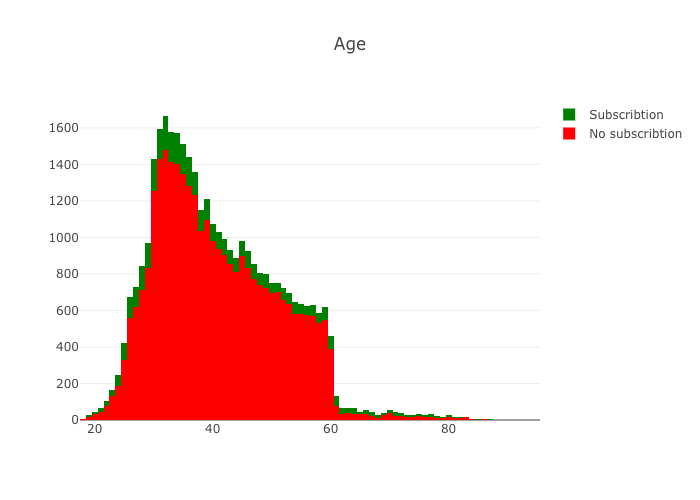

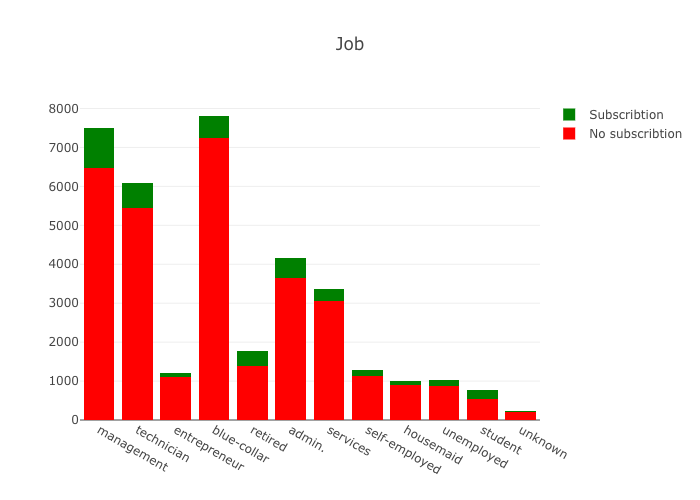

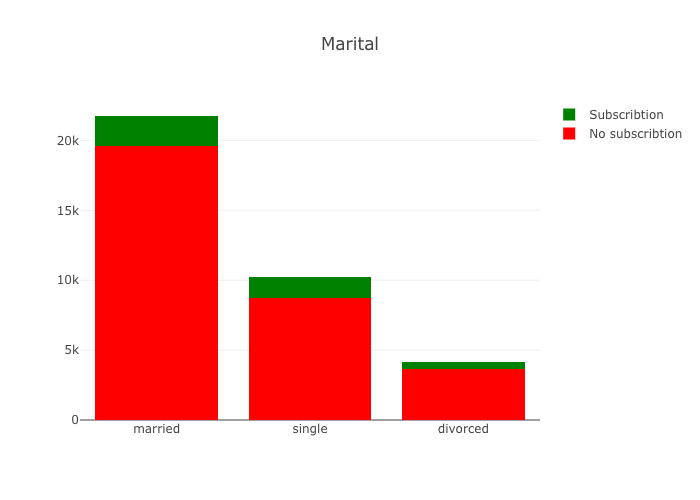

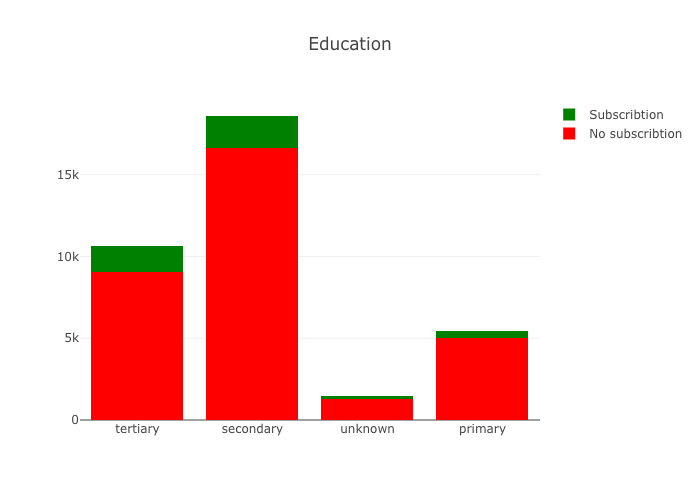

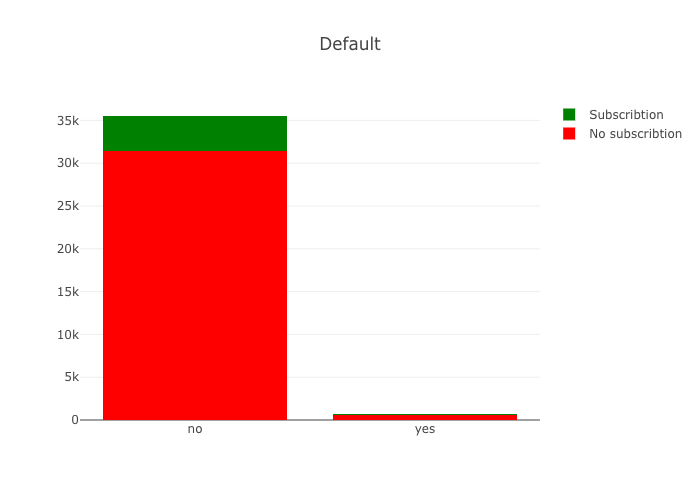

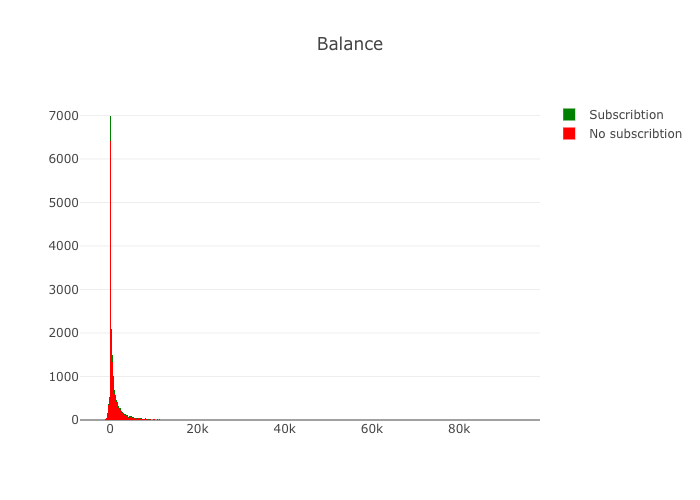

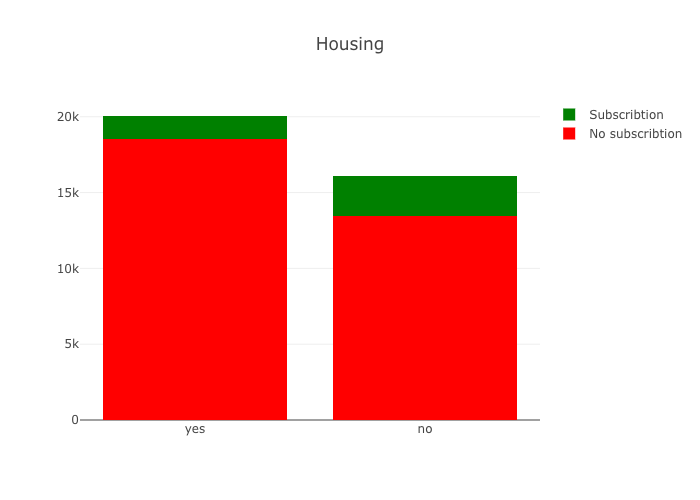

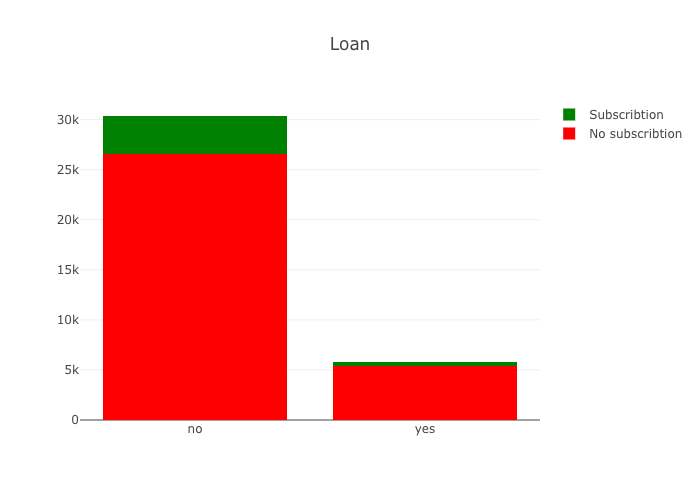

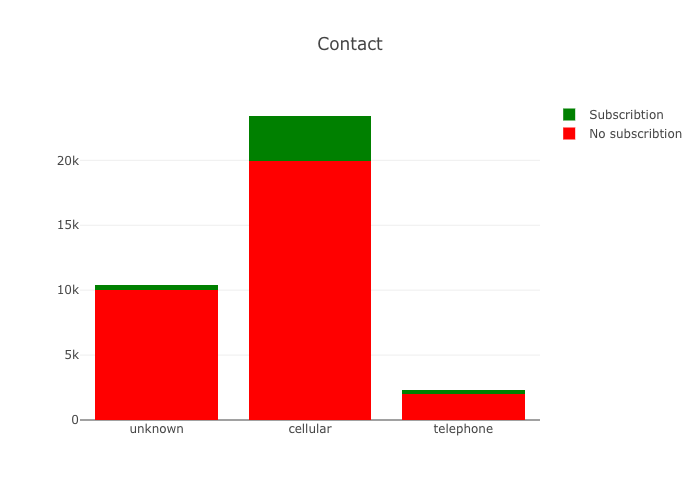

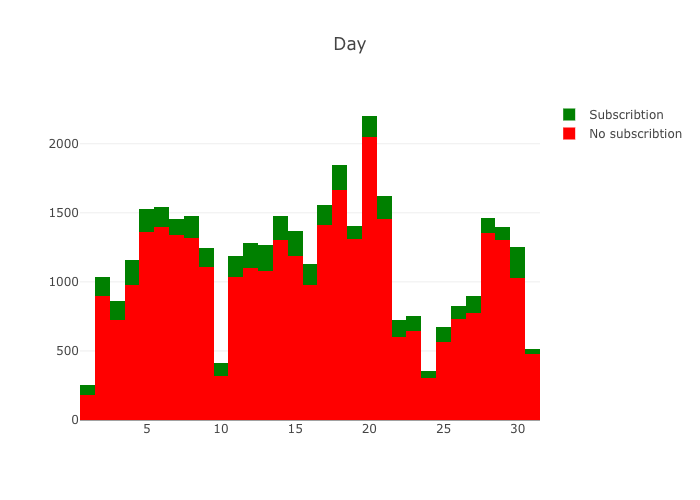

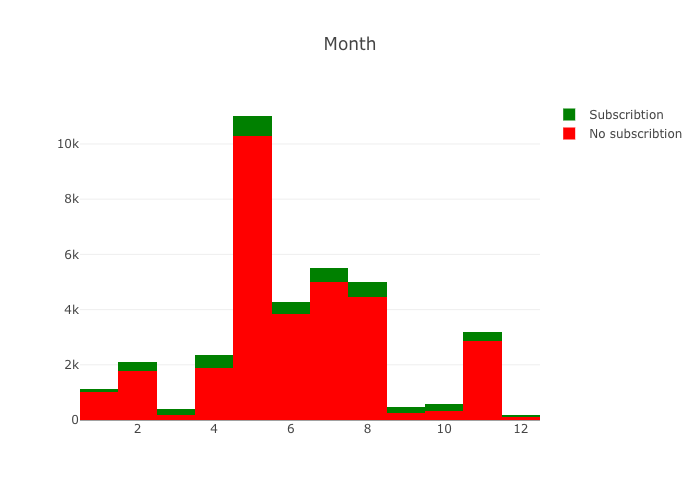

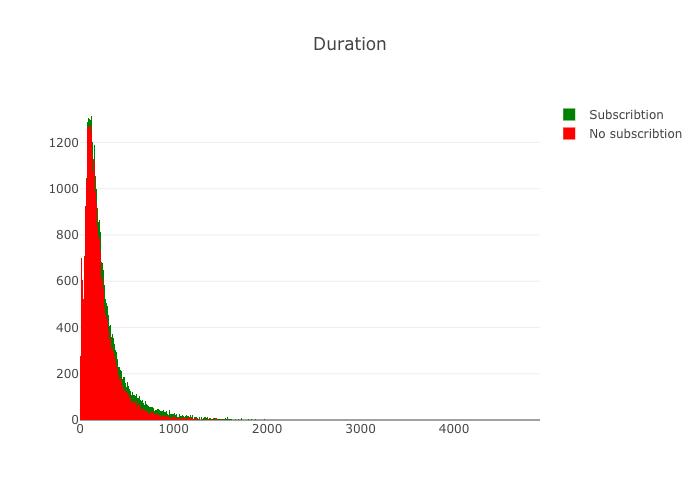

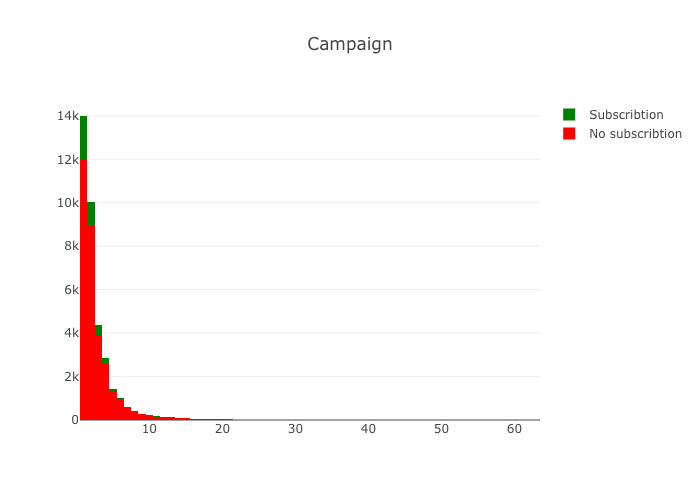

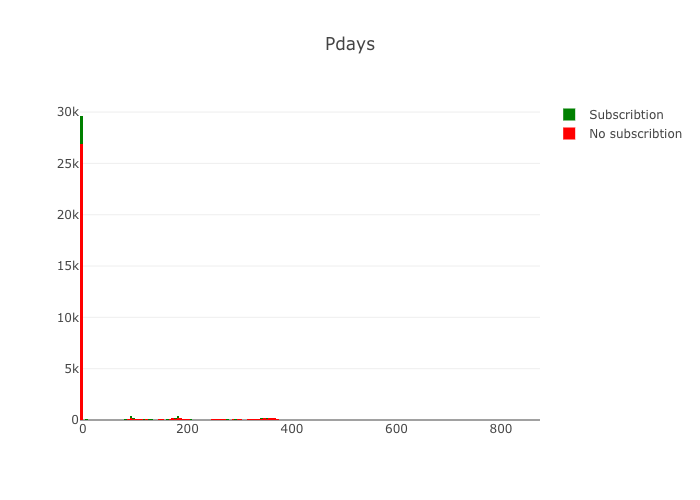

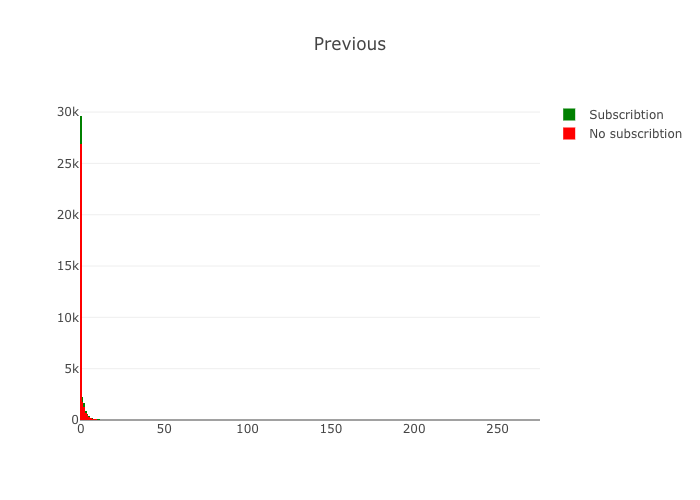

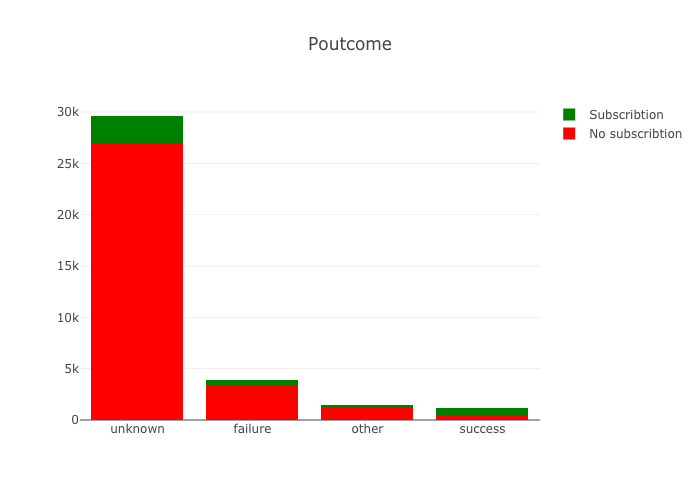

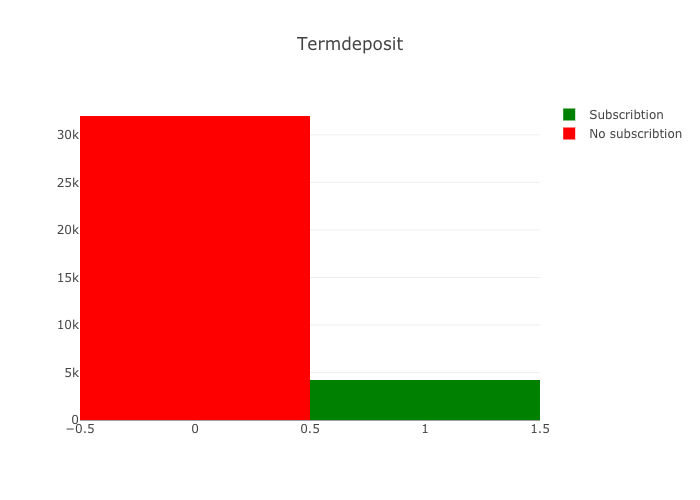

In [5]:
attributes = [atr for atr, typ in dict(df.dtypes).items()]
assistmodule.plotattributes(df, attributes, size=None)

Viewing the histograms for each variable showed that there were no variables that were strongly predictive of the class. Some attributes have quite imbalanced distributions of its values. Our algorithms may benefit from the Feature Engineering of some attribute values. 

## Pairplot

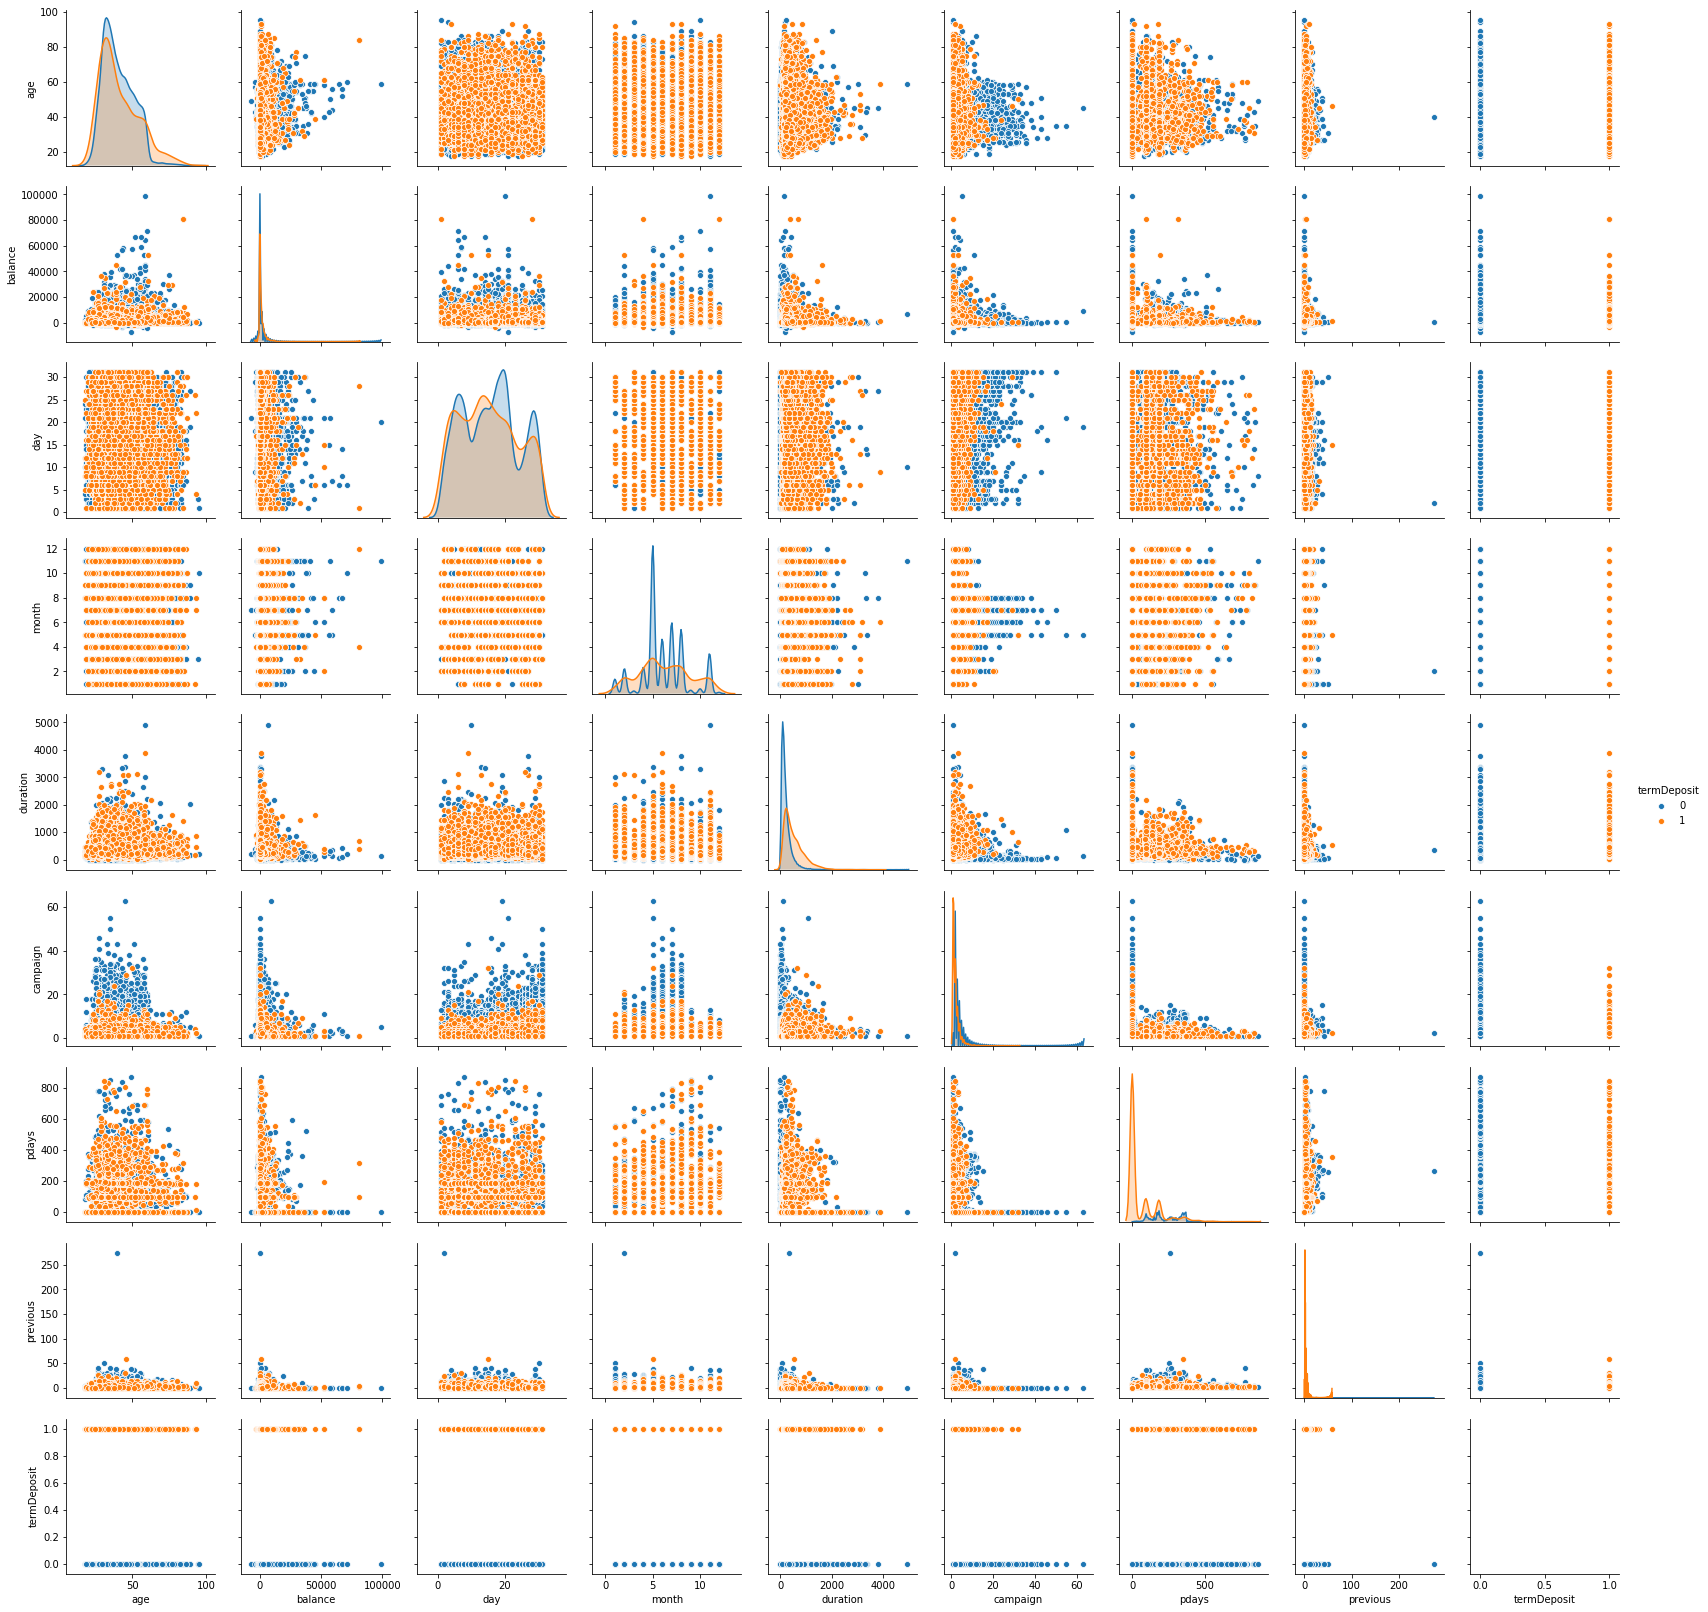

In [7]:
sns.pairplot(df, hue='termDeposit');

Two-dimensional scatter plots don’t show strong class separation; this suggests that several attributes will be needed to separate the two classes.


Job some job attribute values may need to be merged into new groups. 
Some attributes may be irrelevant/redundant. The further exploration is needed to determine the significance of the attributes. The Pearson correlation shows how attributes depend on each other.

In order to see how *categorical* attributes are influencing `termDeposit` we need to *one-hot-encode* them.

In [103]:
df = assistmodule.one_hot_encode_categorical(df)
df.head()

1 job
2 marital
3 education
4 default
6 housing
7 loan
8 contact
15 poutcome


,age,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,...,month,duration,campaign,pdays,previous,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,termDeposit
0,58.0,0,0,0,0,1,0,0,0,0,...,5,261.0,1.0,-1.0,0.0,0,0,0,1,0
1,44.0,0,0,0,0,0,0,0,0,0,...,5,151.0,1.0,-1.0,0.0,0,0,0,1,0
2,33.0,0,0,1,0,0,0,0,0,0,...,5,76.0,1.0,-1.0,0.0,0,0,0,1,0
3,47.0,0,1,0,0,0,0,0,0,0,...,5,92.0,1.0,-1.0,0.0,0,0,0,1,0
4,35.0,0,0,0,0,1,0,0,0,0,...,5,139.0,1.0,-1.0,0.0,0,0,0,1,0


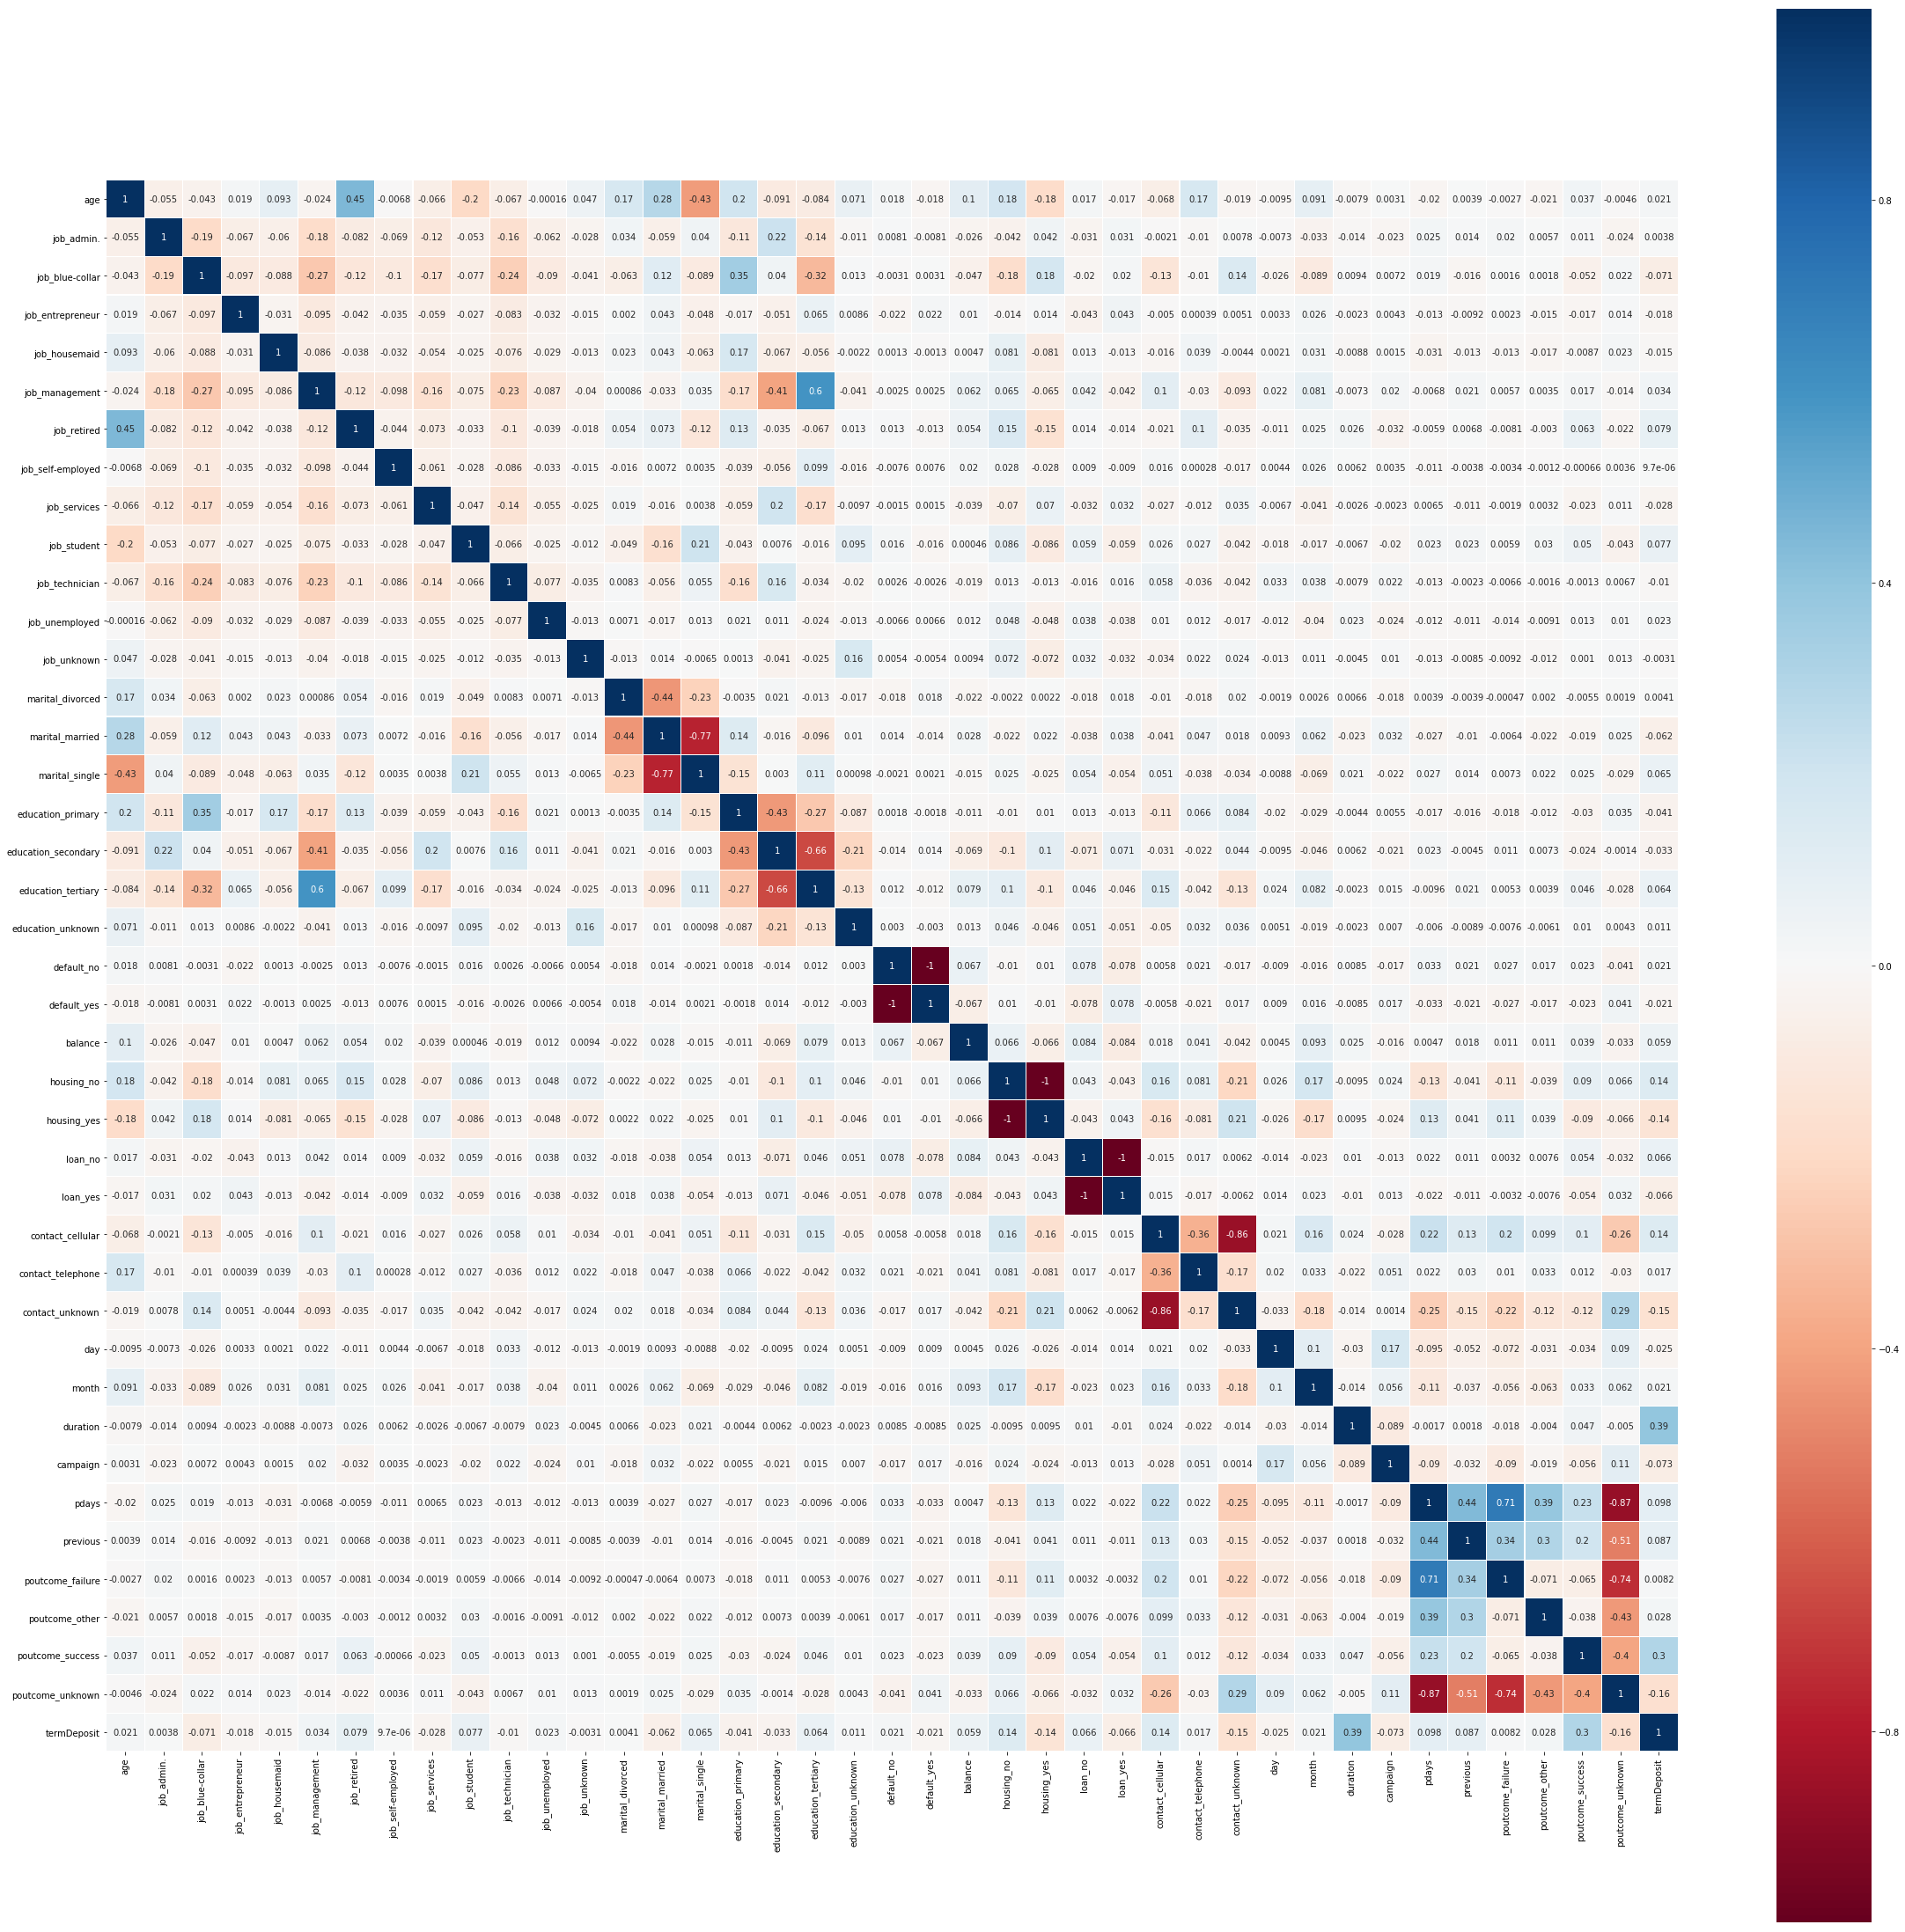

In [10]:
plt.figure(figsize=(40,40))
sns.heatmap(df.astype(float).corr(),linewidths=0.1, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True);

Notice that `poutcome_success` and `duration` positively correlates with `termDeposit`, `contact_unknown` and `poutcome_unknown` negatively, while `pdays`, `day` and `marital_divorced` doesn't seem to be affect the prediction in linear way.

## Initial Classification
Let's apply classification models to our dataset as it is.


### Preparation: standardise numerical attributes

In [104]:
df_numerical = df.select_dtypes([int, float]).drop('termDeposit', axis=1)
# apply standartisation
df_st_numerical = pd.DataFrame(StandardScaler().fit_transform(df_numerical.values), index=df_numerical.index, columns=df_numerical.columns)
df.update(df_st_numerical)

We noticed that the dataframe is not quite balanced, in particular, the success rate grows as number of tries increases. Thus we should shuffle the dataframe

In [105]:
permutation = np.random.RandomState(seed=42).permutation(len(df))
df = df.iloc[permutation]

In [106]:
scores = pd.DataFrame()
df_features = df.drop('termDeposit', axis=1)
df_target = df['termDeposit']

### The Default Classifier

In [107]:
dummycls = DummyClassifier('most_frequent')
scorescv = cross_val_score(dummycls, df_features, df_target, cv=10)
scores['Default'] = pd.Series(scorescv)
scores[['Default']].describe()

,Default
count,10.000000
mean,0.884210
std,0.000102
min,0.884158
25%,0.884158
50%,0.884158
75%,0.884182
max,0.884403


### Decision Tree

In [108]:
for min_impurity_decrease in [0.0001, 0.001, 0.01, 0.1, 1]:
    tree = DecisionTreeClassifier(min_impurity_decrease=min_impurity_decrease)
    scorescv = cross_val_score(tree, df_features, df_target, cv=10)
    name = 'Tree ' + str(min_impurity_decrease)
    scores[name] = pd.Series(scorescv)

scores[[col for col in scores if col.startswith('Tree ')]].describe()

,Tree 0.0001,Tree 0.001,Tree 0.01,Tree 0.1,Tree 1
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.901601,0.897702,0.889546,0.884210,0.884210
std,0.003375,0.003634,0.002839,0.000102,0.000102
min,0.897124,0.892452,0.884435,0.884158,0.884158
25%,0.898514,0.894249,0.887691,0.884158,0.884158
50%,0.902129,0.898935,0.889795,0.884158,0.884158
75%,0.904824,0.900187,0.891416,0.884182,0.884182
max,0.905196,0.902958,0.894111,0.884403,0.884403


Notice the less the `min_impurity_decrease` is, the higher accuracy. However, the $\DeclareMathOperator{\std}{std}\std$ is higher, thus the classification is less _reliable_.

Should we see the tree for some seed with `min_impurity_decrease = 0.001`.

DecisionTrees's Accuracy:  0.8957699751175007
[[3064  142]
 [ 235  176]]


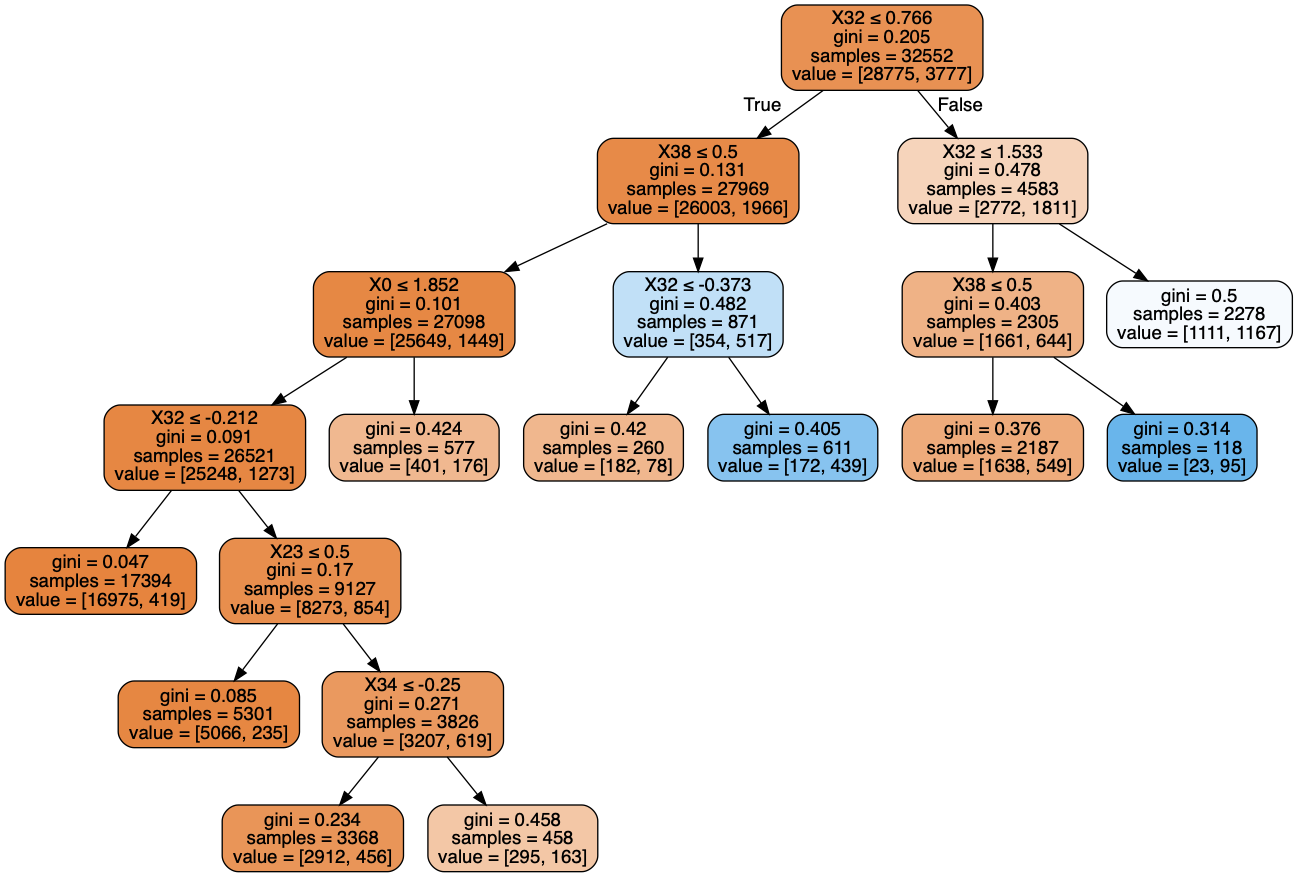

In [109]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('termDeposit', axis=1), df['termDeposit'], test_size=0.1, random_state=45)
tree = DecisionTreeClassifier(min_impurity_decrease=0.001)
tree.fit(X_train, y_train)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, tree.predict(X_test)))
print(confusion_matrix(y_test, tree.predict(X_test)))
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

This classifier is good enough. We can assert that it is better than the default classifier. Because the default classifier mean is way smaller than desision tree mean minus $3\cdot\std$.

### KNN

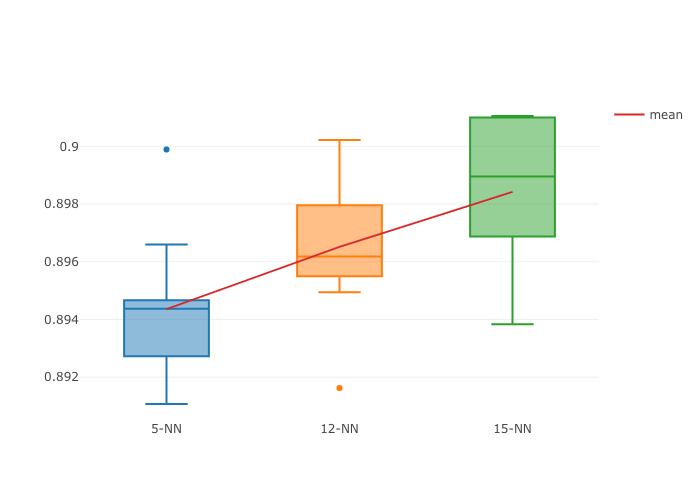

In [110]:
knn_results = pd.DataFrame()

for n in [5,12,15]:
    knn_all_atr = KNeighborsClassifier(n_neighbors=n)
    scores_knn_all = cross_val_score(knn_all_atr, df_features, df_target, cv=10)
    knn_results['{}-NN'.format(n)] = pd.Series(scores_knn_all)

scores['{} Nearest N'.format(n)] = knn_results['{}-NN'.format(n)]


data = []
for col in knn_results.columns:
    data.append(go.Box(y=knn_results[col], name=col, showlegend=False ) )

data.append(go.Scatter(x=knn_results.columns, y = knn_results.mean(), mode='lines', name='mean'))

fig = go.Figure(data=data)

if exporting == True:
    static_image_bytes = pio.to_image(fig, format='png')
    display(Image(static_image_bytes))
else:
    display(iplot(fig))

### Logistic Regression

In [111]:
logreg = LogisticRegression(random_state=0, solver='sag', max_iter=10000)
scores_logreg = cross_val_score(logreg, df_features, df_target, cv=10)
scores['Logistic R'] = pd.Series(scores_logreg)

### Random Forest

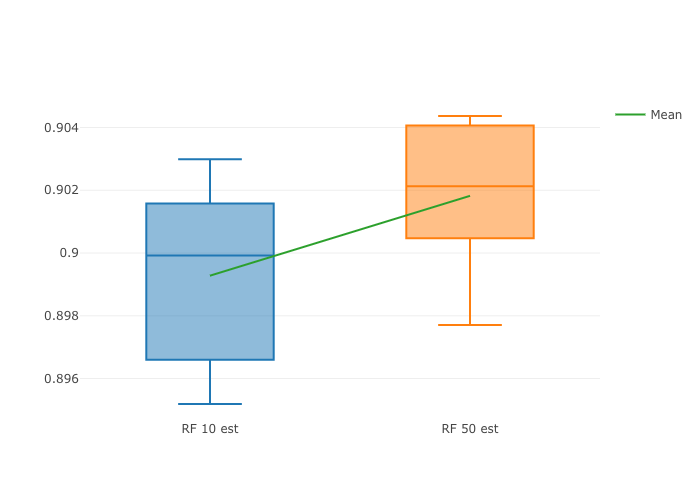

In [112]:
scores_randforest = pd.DataFrame()
for n in [10, 50]:
    randforest = RandomForestClassifier(n_estimators=n, n_jobs=-1)
    scores_randforest_cvs = cross_val_score(randforest, df_features, df_target, cv=10)
    scores_randforest['RF {} est'.format(n)] = pd.Series(scores_randforest_cvs)
    if n in [10, 50]:
        scores['RandomF {} trees'.format(n)] = pd.Series(scores_randforest_cvs)

data = []
for col in scores_randforest.columns:
    data.append(go.Box(y=scores_randforest[col], name=col, showlegend=False))

data.append(go.Scatter(x=scores_randforest.columns, y = scores_randforest.mean(), mode='lines', name='Mean'))

fig = go.Figure(data=data)
if exporting == True:
    static_image_bytes = pio.to_image(fig, format='png')
    display(Image(static_image_bytes))
else:
    display(iplot(fig))

After having tried different number of trees the conclusion is, the more trees in the forest, the better.

### Summary

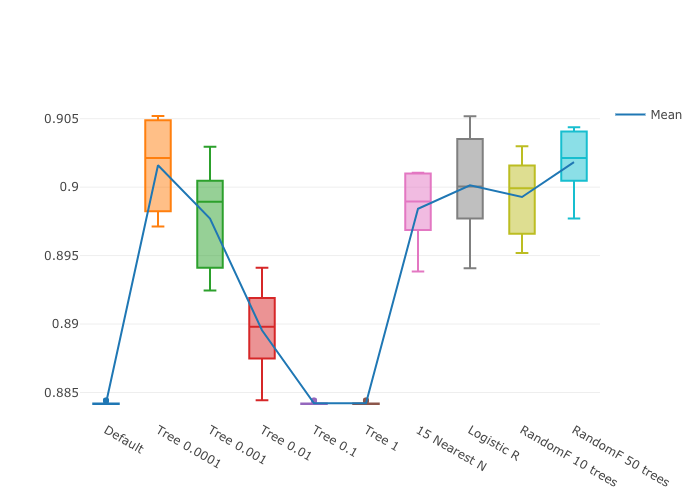

In [113]:
data = []
for col in scores.columns:
    data.append(go.Box(y=scores[col], name=col, showlegend=False))

data.append(go.Scatter(x=scores.columns, y = scores.mean(), mode='lines', name='Mean'))

fig = go.Figure(data=data)
if exporting == True:
    static_image_bytes = pio.to_image(fig, format='png')
    display(Image(static_image_bytes))
else:
    display(iplot(fig))

## Initial Cost-Sensitive Classification


In [114]:
scores = pd.DataFrame(index=range(10))

### The Default Classifier

DummyClassifier(constant=None, random_state=None, strategy='stratified') 

Fold 1/10 for Default Classifier with lowest cost 3220.00 at t = 0.00
Fold 2/10 for Default Classifier with lowest cost 3190.00 at t = 0.00
Fold 3/10 for Default Classifier with lowest cost 3179.00 at t = 0.00
Fold 4/10 for Default Classifier with lowest cost 3190.00 at t = 0.00
Fold 5/10 for Default Classifier with lowest cost 3206.00 at t = 0.00
Fold 6/10 for Default Classifier with lowest cost 3173.00 at t = 0.00
Fold 7/10 for Default Classifier with lowest cost 3183.00 at t = 0.00
Fold 8/10 for Default Classifier with lowest cost 3199.00 at t = 0.00
Fold 9/10 for Default Classifier with lowest cost 3208.00 at t = 0.00
Fold 10/10 for Default Classifier with lowest cost 3233.00 at t = 0.00
The lowest cost will be reached if t is equal to       0.00
The lowest average cost would be                           3198.1.


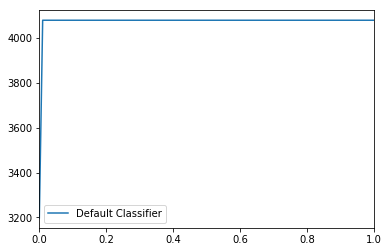

In [115]:
from assistmodule import thresholding, boxplot_scores

X = df_features.values
y = df_target.values

cls = DummyClassifier()
threshold = thresholding(X, y, cls, name='Default Classifier', verbose=False)
scores = pd.concat([scores, threshold['mincost_df']], axis=1)

So the smallest average cost is 3198.1 for threshold $t = 0$, which is the same as predicting 'yes' for all cases.

### Decision Tree

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=1, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') 

Fold 1/10 for DTree with MID 1 with lowest cost 3220.00 at t = 0.00
Fold 2/10 for DTree with MID 1 with lowest cost 3190.00 at t = 0.00
Fold 3/10 for DTree with MID 1 with lowest cost 3179.00 at t = 0.00
Fold 4/10 for DTree with MID 1 with lowest cost 3190.00 at t = 0.00
Fold 5/10 for DTree with MID 1 with lowest cost 3206.00 at t = 0.00
Fold 6/10 for DTree with MID 1 with lowest cost 3173.00 at t = 0.00
Fold 7/10 for DTree with MID 1 with lowest cost 3183.00 at t = 0.00
Fold 8/10 for DTree with MID 1 with lowest cost 3199.00 at t = 0.00
Fold 9/10 for DTree with MID 1 with lowest cost 3208.00 at t = 0.00
Fold 10/10 for DTree with MID 1 with l

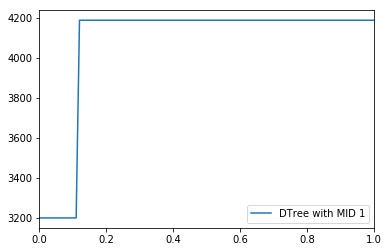




DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.1, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') 

Fold 1/10 for DTree with MID 0.1 with lowest cost 3220.00 at t = 0.00
Fold 2/10 for DTree with MID 0.1 with lowest cost 3190.00 at t = 0.00
Fold 3/10 for DTree with MID 0.1 with lowest cost 3179.00 at t = 0.00
Fold 4/10 for DTree with MID 0.1 with lowest cost 3190.00 at t = 0.00
Fold 5/10 for DTree with MID 0.1 with lowest cost 3206.00 at t = 0.00
Fold 6/10 for DTree with MID 0.1 with lowest cost 3173.00 at t = 0.00
Fold 7/10 for DTree with MID 0.1 with lowest cost 3183.00 at t = 0.00
Fold 8/10 for DTree with MID 0.1 with lowest cost 3199.00 at t = 0.00
Fold 9/10 for DTree with MID 0.1 with lowest cost 3208.00 at t = 0.00
Fold 10/10 for 

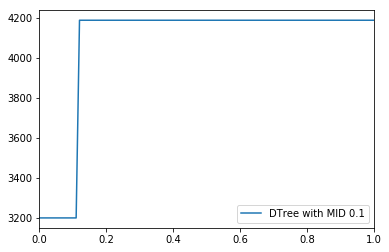




DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.01, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') 

Fold 1/10 for DTree with MID 0.01 with lowest cost 1882.00 at t = 0.06
Fold 2/10 for DTree with MID 0.01 with lowest cost 2001.00 at t = 0.06
Fold 3/10 for DTree with MID 0.01 with lowest cost 1892.00 at t = 0.06
Fold 4/10 for DTree with MID 0.01 with lowest cost 2087.00 at t = 0.06
Fold 5/10 for DTree with MID 0.01 with lowest cost 2084.00 at t = 0.06
Fold 6/10 for DTree with MID 0.01 with lowest cost 2146.00 at t = 0.06
Fold 7/10 for DTree with MID 0.01 with lowest cost 2123.00 at t = 0.06
Fold 8/10 for DTree with MID 0.01 with lowest cost 2123.00 at t = 0.06
Fold 9/10 for DTree with MID 0.01 with lowest cost 1919.00 at t = 0.06
Fold 

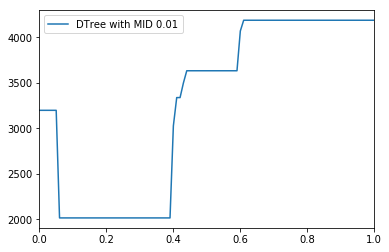




DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.001, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') 

Fold 1/10 for DTree with MID 0.001 with lowest cost 1494.00 at t = 0.05
Fold 2/10 for DTree with MID 0.001 with lowest cost 1401.00 at t = 0.05
Fold 3/10 for DTree with MID 0.001 with lowest cost 1480.00 at t = 0.05
Fold 4/10 for DTree with MID 0.001 with lowest cost 1436.00 at t = 0.05
Fold 5/10 for DTree with MID 0.001 with lowest cost 1348.00 at t = 0.06
Fold 6/10 for DTree with MID 0.001 with lowest cost 1690.00 at t = 0.06
Fold 7/10 for DTree with MID 0.001 with lowest cost 1588.00 at t = 0.05
Fold 8/10 for DTree with MID 0.001 with lowest cost 1560.00 at t = 0.06
Fold 9/10 for DTree with MID 0.001 with lowest cost 1434.00 at t = 

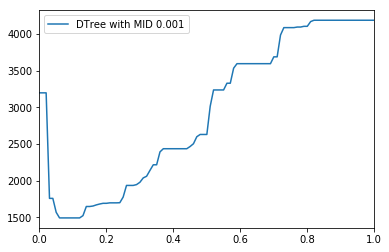




DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0001, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') 

Fold 1/10 for DTree with MID 0.0001 with lowest cost 1153.00 at t = 0.11
Fold 2/10 for DTree with MID 0.0001 with lowest cost 1204.00 at t = 0.13
Fold 3/10 for DTree with MID 0.0001 with lowest cost 1229.00 at t = 0.06
Fold 4/10 for DTree with MID 0.0001 with lowest cost 1153.00 at t = 0.07
Fold 5/10 for DTree with MID 0.0001 with lowest cost 1136.00 at t = 0.08
Fold 6/10 for DTree with MID 0.0001 with lowest cost 1293.00 at t = 0.06
Fold 7/10 for DTree with MID 0.0001 with lowest cost 1244.00 at t = 0.06
Fold 8/10 for DTree with MID 0.0001 with lowest cost 1210.00 at t = 0.11
Fold 9/10 for DTree with MID 0.0001 with lowest cost 1134.

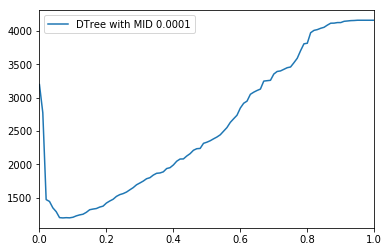

In [116]:
for mid in [1, 0.1, 0.01, 0.001, 0.0001]:
    cls = DecisionTreeClassifier(min_impurity_decrease=mid)
    threshold = thresholding(X, y, cls, name='DTree with MID %s' % mid)
    scores = pd.concat([scores, threshold['mincost_df']], axis=1)

The lowest average cost is 1199.3 when _Minimum Impurity Decrease_ is 0.0001 is equal to and _threshold_ is 0.07.

### KNN

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform') 

Fold 1/10 for 5 Nearest Neighbours with lowest cost 1477.00 at t = 0.01
Fold 2/10 for 5 Nearest Neighbours with lowest cost 1563.00 at t = 0.01
Fold 3/10 for 5 Nearest Neighbours with lowest cost 1620.00 at t = 0.01
Fold 4/10 for 5 Nearest Neighbours with lowest cost 1610.00 at t = 0.01
Fold 5/10 for 5 Nearest Neighbours with lowest cost 1400.00 at t = 0.01
Fold 6/10 for 5 Nearest Neighbours with lowest cost 1626.00 at t = 0.01
Fold 7/10 for 5 Nearest Neighbours with lowest cost 1655.00 at t = 0.01
Fold 8/10 for 5 Nearest Neighbours with lowest cost 1416.00 at t = 0.01
Fold 9/10 for 5 Nearest Neighbours with lowest cost 1512.00 at t = 0.01
Fold 10/10 for 5 Nearest Neighbours with lowest cost 1572.00 at t = 0.01
The lowest cost will be reached if t is equal to       0.01
The lowest average cost would be                  

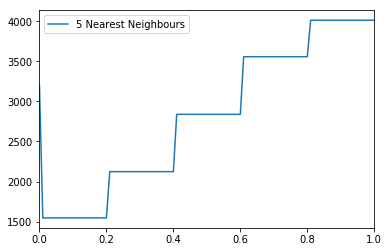




KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=12, p=2,
           weights='uniform') 

Fold 1/10 for 12 Nearest Neighbours with lowest cost 1312.00 at t = 0.09
Fold 2/10 for 12 Nearest Neighbours with lowest cost 1335.00 at t = 0.09
Fold 3/10 for 12 Nearest Neighbours with lowest cost 1459.00 at t = 0.01
Fold 4/10 for 12 Nearest Neighbours with lowest cost 1388.00 at t = 0.09
Fold 5/10 for 12 Nearest Neighbours with lowest cost 1339.00 at t = 0.09
Fold 6/10 for 12 Nearest Neighbours with lowest cost 1489.00 at t = 0.01
Fold 7/10 for 12 Nearest Neighbours with lowest cost 1395.00 at t = 0.09
Fold 8/10 for 12 Nearest Neighbours with lowest cost 1328.00 at t = 0.09
Fold 9/10 for 12 Nearest Neighbours with lowest cost 1341.00 at t = 0.09
Fold 10/10 for 12 Nearest Neighbours with lowest cost 1401.00 at t = 0.01
The lowest cost will be reached if t is equal to       0.09
The lowest average cost would be    

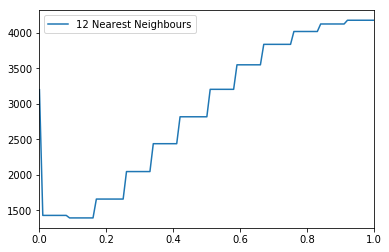




KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform') 

Fold 1/10 for 15 Nearest Neighbours with lowest cost 1270.00 at t = 0.07
Fold 2/10 for 15 Nearest Neighbours with lowest cost 1319.00 at t = 0.14
Fold 3/10 for 15 Nearest Neighbours with lowest cost 1378.00 at t = 0.07
Fold 4/10 for 15 Nearest Neighbours with lowest cost 1341.00 at t = 0.07
Fold 5/10 for 15 Nearest Neighbours with lowest cost 1232.00 at t = 0.07
Fold 6/10 for 15 Nearest Neighbours with lowest cost 1510.00 at t = 0.01
Fold 7/10 for 15 Nearest Neighbours with lowest cost 1338.00 at t = 0.07
Fold 8/10 for 15 Nearest Neighbours with lowest cost 1294.00 at t = 0.07
Fold 9/10 for 15 Nearest Neighbours with lowest cost 1277.00 at t = 0.07
Fold 10/10 for 15 Nearest Neighbours with lowest cost 1336.00 at t = 0.07
The lowest cost will be reached if t is equal to       0.07
The lowest average cost would be    

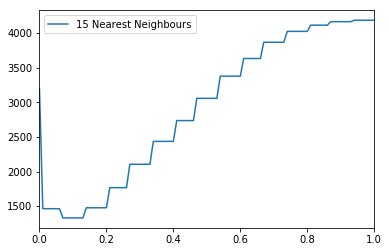

In [117]:
for n in [5,12,15]:
    cls = KNeighborsClassifier(n_neighbors=n)
    threshold = thresholding(X, y, cls, name='%d Nearest Neighbours' % n)
    scores = pd.concat([scores, threshold['mincost_df']], axis=1)

The lowest average cost is 1330.1 for 15 _nearest neighbours_ and _threshold_ is 0.07.

### Logistic Regression

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='sag',
          tol=0.0001, verbose=0, warm_start=False) 

Fold 1/10 for Logistic Regression with lowest cost 1286.00 at t = 0.10
Fold 2/10 for Logistic Regression with lowest cost 1332.00 at t = 0.11
Fold 3/10 for Logistic Regression with lowest cost 1357.00 at t = 0.09
Fold 4/10 for Logistic Regression with lowest cost 1418.00 at t = 0.10
Fold 5/10 for Logistic Regression with lowest cost 1231.00 at t = 0.11
Fold 6/10 for Logistic Regression with lowest cost 1439.00 at t = 0.09
Fold 7/10 for Logistic Regression with lowest cost 1313.00 at t = 0.09
Fold 8/10 for Logistic Regression with lowest cost 1275.00 at t = 0.09
Fold 9/10 for Logistic Regression with lowest cost 1294.00 at t = 0.10
Fold 10/10 for Logistic Regression with lowest cost 1259.00 at t = 0.10
The lowest cost will be r

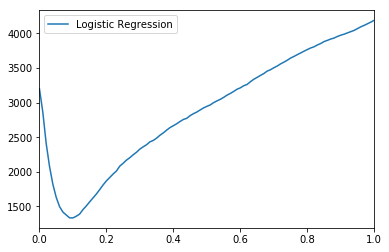

In [118]:
cls = LogisticRegression(random_state=0, solver='sag', max_iter=10000)
threshold = thresholding(X, y, cls, name='Logistic Regression')
scores = pd.concat([scores, threshold['mincost_df']], axis=1)

The lowest average cost is 1335.0 when _threshold_ is 0.1.

### Random Forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 

Fold 1/10 for RForest for 10 with lowest cost 1163.00 at t = 0.11
Fold 2/10 for RForest for 10 with lowest cost 1207.00 at t = 0.11
Fold 3/10 for RForest for 10 with lowest cost 1395.00 at t = 0.11
Fold 4/10 for RForest for 10 with lowest cost 1301.00 at t = 0.11
Fold 5/10 for RForest for 10 with lowest cost 1122.00 at t = 0.11
Fold 6/10 for RForest for 10 with lowest cost 1376.00 at t = 0.11
Fold 7/10 for RForest for 10 with lowest cost 1247.00 at t = 0.11
Fold 8/10 for RForest for 10 with lowest cost 1300.00 at t = 0.11
Fold 9/10 for RForest for 10 with lowest cost 12

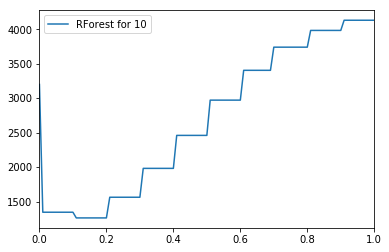




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 

Fold 1/10 for RForest for 50 with lowest cost 1049.00 at t = 0.17
Fold 2/10 for RForest for 50 with lowest cost 960.00 at t = 0.11
Fold 3/10 for RForest for 50 with lowest cost 1043.00 at t = 0.09
Fold 4/10 for RForest for 50 with lowest cost 1050.00 at t = 0.11
Fold 5/10 for RForest for 50 with lowest cost 955.00 at t = 0.13
Fold 6/10 for RForest for 50 with lowest cost 1064.00 at t = 0.09
Fold 7/10 for RForest for 50 with lowest cost 1083.00 at t = 0.13
Fold 8/10 for RForest for 50 with lowest cost 1013.00 at t = 0.11
Fold 9/10 for RForest for 50 with lowest cost 9

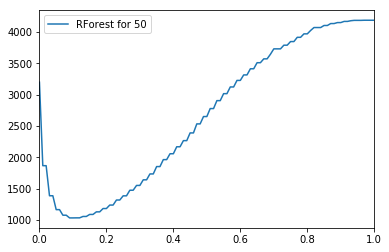

In [119]:
for n in [10, 50]:
    cls = RandomForestClassifier(n_estimators=n, n_jobs=-1)
    threshold = thresholding(X, y, cls, name='RForest for %d' % n)
    scores = pd.concat([scores, threshold['mincost_df']], axis=1)

The lowest average cost is 1027.4 for 50 _trees_ and for _threshold_ equal to 0.11.


### Summary

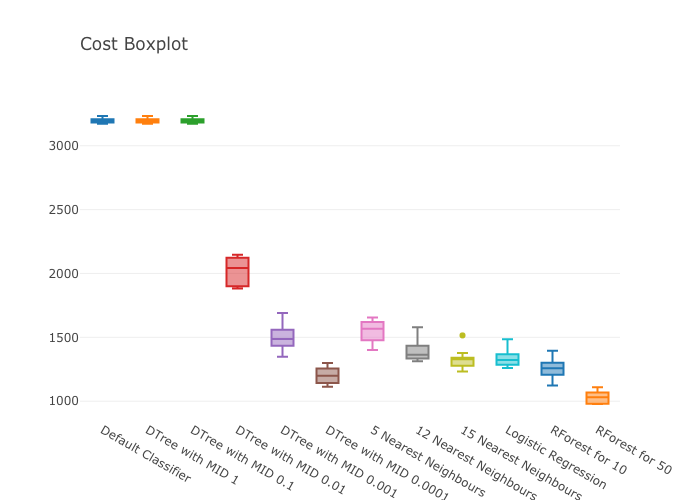

In [121]:
boxplot_scores(scores)

The Random Forest classifier had demonstrated the lowest cost classification. The best average score is 1027.4.

Now we have an understanding what classifiers we need to consider. For feature processing we will focus on the increasing accuracy and cost reduction for the following classifiers (Top 4)

* Decision Tree with MID = 0.0001 (minimum impurity decrease)
* 15 Nearest Neighbours
* Logistic Regression
* Random Forests with 50 Trees

Let's proceed to Feature Engineering. After each feature engineering step we will run classification for the selected 4 classifiers with the highest _accuracy_ (lower _cost_).

finished Tree 0.0001
finished 15-NN
finished Logistic R
finished RandomF 50 trees


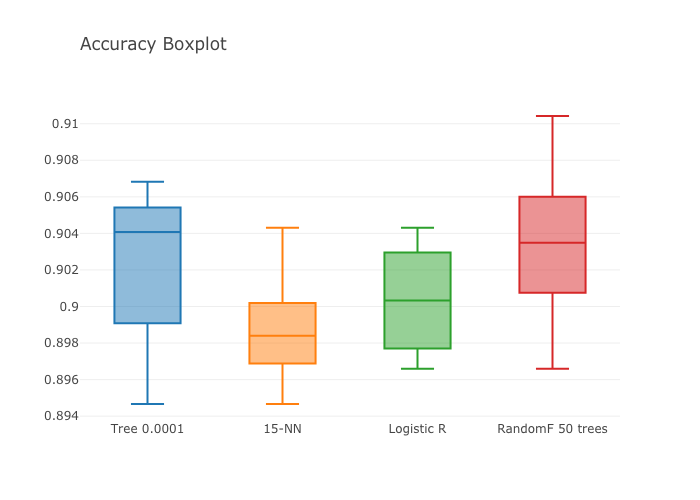

None

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0001, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') 

Fold 1/10 for Tree 0.0001 with lowest cost 1252.00 at t = 0.06
Fold 2/10 for Tree 0.0001 with lowest cost 1338.00 at t = 0.11
Fold 3/10 for Tree 0.0001 with lowest cost 1242.00 at t = 0.09
Fold 4/10 for Tree 0.0001 with lowest cost 1158.00 at t = 0.10
Fold 5/10 for Tree 0.0001 with lowest cost 1148.00 at t = 0.08
Fold 6/10 for Tree 0.0001 with lowest cost 1059.00 at t = 0.07
Fold 7/10 for Tree 0.0001 with lowest cost 1055.00 at t = 0.11
Fold 8/10 for Tree 0.0001 with lowest cost 1191.00 at t = 0.06
Fold 9/10 for Tree 0.0001 with lowest cost 1101.00 at t = 0.11
Fold 10/10 for Tree 0.0001 with lowest cost 1211.00 at t = 0.11
The lowest cos

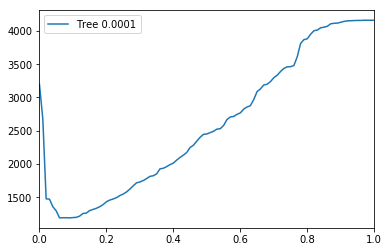




KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform') 

Fold 1/10 for 15-NN with lowest cost 1295.00 at t = 0.07
Fold 2/10 for 15-NN with lowest cost 1318.00 at t = 0.07
Fold 3/10 for 15-NN with lowest cost 1349.00 at t = 0.07
Fold 4/10 for 15-NN with lowest cost 1269.00 at t = 0.07
Fold 5/10 for 15-NN with lowest cost 1437.00 at t = 0.07
Fold 6/10 for 15-NN with lowest cost 1253.00 at t = 0.07
Fold 7/10 for 15-NN with lowest cost 1322.00 at t = 0.07
Fold 8/10 for 15-NN with lowest cost 1282.00 at t = 0.07
Fold 9/10 for 15-NN with lowest cost 1310.00 at t = 0.07
Fold 10/10 for 15-NN with lowest cost 1430.00 at t = 0.07
The lowest cost will be reached if t is equal to       0.07
The lowest average cost would be                           1326.5.


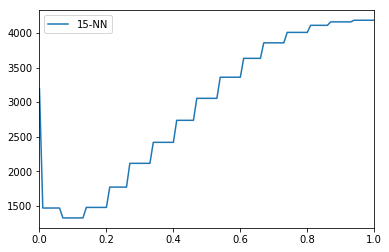




LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='sag',
          tol=0.0001, verbose=0, warm_start=False) 

Fold 1/10 for Logistic R with lowest cost 1366.00 at t = 0.10
Fold 2/10 for Logistic R with lowest cost 1413.00 at t = 0.11
Fold 3/10 for Logistic R with lowest cost 1387.00 at t = 0.09
Fold 4/10 for Logistic R with lowest cost 1236.00 at t = 0.08
Fold 5/10 for Logistic R with lowest cost 1344.00 at t = 0.10
Fold 6/10 for Logistic R with lowest cost 1236.00 at t = 0.12
Fold 7/10 for Logistic R with lowest cost 1244.00 at t = 0.09
Fold 8/10 for Logistic R with lowest cost 1228.00 at t = 0.10
Fold 9/10 for Logistic R with lowest cost 1273.00 at t = 0.10
Fold 10/10 for Logistic R with lowest cost 1344.00 at t = 0.08
The lowest cost will be reached if t is equal to       0.09
The lowest average cost would be                    

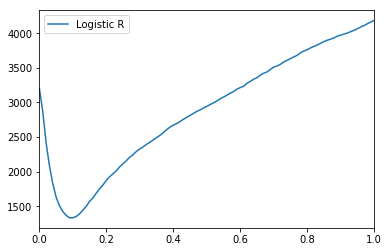




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 

Fold 1/10 for RandomF 50 trees with lowest cost 1120.00 at t = 0.13
Fold 2/10 for RandomF 50 trees with lowest cost 1001.00 at t = 0.09
Fold 3/10 for RandomF 50 trees with lowest cost 1002.00 at t = 0.09
Fold 4/10 for RandomF 50 trees with lowest cost 1009.00 at t = 0.09
Fold 5/10 for RandomF 50 trees with lowest cost 1053.00 at t = 0.13
Fold 6/10 for RandomF 50 trees with lowest cost 964.00 at t = 0.11
Fold 7/10 for RandomF 50 trees with lowest cost 959.00 at t = 0.11
Fold 8/10 for RandomF 50 trees with lowest cost 998.00 at t = 0.09
Fold 9/10 for RandomF 50 trees w

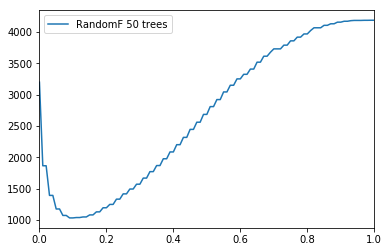

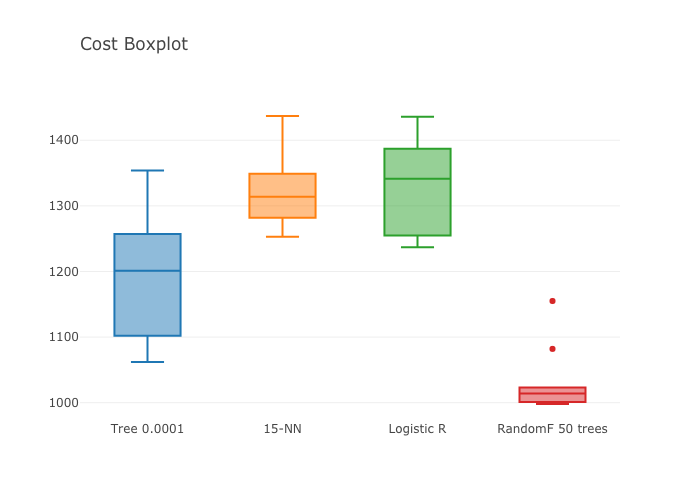

None

In [122]:
from assistmodule import classification, cs_classification, boxplot_scores

permutation = np.random.RandomState(seed=42).permutation(len(df))
df_test = df.iloc[permutation]

X = df_test.drop('termDeposit', axis=1).values
y = df_test['termDeposit'].values

display(boxplot_scores(classification(X, y), name='Accuracy'))
display(boxplot_scores(cs_classification(X, y), name='Cost'));

## Side Note

Although I have tested many other models and parameters to choose top 4 best performing, there is a significant chance that there are plenty of other options. It is infeasible to test the model on all possible combinations of parameters, even for the selected 4 models. We will try to improve accuracy for the best performing models by applying Feature Engineering techniques. After that, we will work with Parameter Tuning for the best model. 

Yet, such approach doesn't guarantee the best score, because we don't go through all parameters (in some Gradient Decent fashion).

Notice that I don't use Naive Bayes classifier. The reason is that the dataset has categorical and numerical variables. In order to apply NB, we need to apply _Gaussian NB_ to numerical attributes and _Bernoulli NB_ for categorical attributes separately, then apply _Voting Meta Classifier_ to get the final prediction. Judging from my experience on lab sessions, I decided to replace _NB_ with more promising classifier _Random Forest_. Namely because some attributes are not _Normally distributed_ (necessary condition for _NB_ classifier). Also, NB is prone to overfitting, especially if the dataset is highly unbalanced.